In [1]:
import math
import string
import matplotlib as mpl
import numpy.matlib
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd
import random

C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
#⽣成区间[a,b]内的随机数
def random_number(a,b):
    return (b-a)*random.random()+a

In [4]:
#⽣成⼀个矩阵，⼤⼩为m*n,并且设置默认零矩阵
def makematrix(m, n, fill=0.0):
    a = []
    for i in range(m):
        a.append([fill]*n)
    return np.array(a)

In [7]:
#函数sigmoid(),两个函数都可以作为激活函数
def sigmoid(x):
    #return np.tanh(x)
    return(1-np.exp(-1*x))/(1+np.exp(-1*x))

#函数sigmoid的派⽣函数
def derived_sigmoid(x):
    return 1-(np.tanh(x))**2
    #return (2*np.exp((-1)*x)/((1+np.exp(-1*x)**2)))

In [53]:
#构造三层BP⽹络架构
class BPNN:
    def __init__(self,num_in,num_hidden,num_out):
        #输入层，隐藏层，输出层的节点数
        self.num_in =num_in + 1 #增加一个偏置节点
        self.num_hidden = num_hidden + 1 #增加一个偏置节点
        self.num_out=num_out
        #激活神经⽹络的所有节点（向量）
        self.active_in = np.array([-1.0]*self.num_in)
        self.active_hidden = np.array([-1.0]*self.num_hidden)
        self.active_out = np.array([1.0]*self.num_out)
        #创建权重矩阵
        self.wight_in = makematrix(self.num_in, self.num_hidden)
        self.wight_out = makematrix(self.num_hidden, self.num_out)
        #对权值矩阵赋初值
        for i in range(self.num_in):
            for j in range(self.num_hidden):
                self.wight_in[i][j] = random_number(0.1, 0.1)
        for i in range(self.num_hidden):
            for j in range(self.num_out):
                self.wight_out[i][j] = random_number(0.1, 0.1)
        #偏差
        for j in range(self.num_hidden):
            self.wight_in[0][j] = 0.1
        for j in range(self.num_out):
            self.wight_in[0][j] = 0.1
        #最后建⽴动量因⼦（矩阵）
        self.ci = makematrix(self.num_in, self.num_hidden)
        self.co = makematrix(self.num_hidden, self.num_out)
    #信号正向传播
    def update(self, inputs):
        if len(inputs) != self.num_in-1:
            raise ValueError('与输⼊层节点数不符')
        #数据输⼊输⼊层
        self.active_in[1:self.num_in]=inputs
        #数据在隐藏层的处理
        self.sum_hidden=np.dot(self.wight_in.T,self.active_in.reshape(-1,1)) #点乘
        self.active_hidden=sigmoid(self.sum_hidden) #active_hidden[]是处理完输⼊数据之后存储，作为输出层的输⼊数据
        self.active_hidden[0]=-1
        #数据在输出层的处理
        self.sum_out=np.dot(self.wight_out.T,self.active_hidden) #点乘
        self.active_out = sigmoid(self.sum_out) #与上同理
        return self.active_out
    #误差反向传播
    def errorbackpropagate(self, targets, lr,m): #lr是学习率
        if self.num_out==1:
            targets=[targets]
        if len(targets) != self.num_out:
            raise ValueError('与输出层节点数不符！')
        #误差
        error=(1/2)*np.dot((targets.reshape(-1,1)-self.active_out).T,(targets.reshape(-1,1)-self.active_out))
        #输出误差信号
        self.error_out=(targets.reshape(-1,1)-self.active_out)*derived_sigmoid(self.sum_out)
        #隐层误差信号
        #self.error_hidden=np.dot(self.wight_out.reshape(-1,1),self.error_out.reshape(-1,1))*self.active_hidden*(1-self.active_hidden)
        self.error_hidden=np.dot(self.wight_out,self.error_out)*derived_sigmoid(self.sum_hidden)
        #更新权值
        #隐藏
        self.wight_out=self.wight_out+lr*np.dot(self.error_out,self.active_hidden.reshape(1,-1)).T+m*self.co
        self.co=lr*np.dot(self.error_out,self.active_hidden.reshape(1,-1)).T
        #输⼊
        self.wight_in=self.wight_in+lr*np.dot(self.error_hidden,self.active_in.reshape(1,-1)).T+m*self.ci
        self.ci=lr*np.dot(self.error_hidden,self.active_in.reshape(1,-1)).T
        return error
        #测试
    def test(self, patterns):
        for i in patterns:
            print(i[0:self.num_in-1], '->', self.update(i[0:self.num_in-1]))
        return self.update(i[0:self.num_in-1])
    #权值
    def weights(self):
        print("输⼊层权重")
        print(self.wight_in)
        print("输出层权重")
        print(self.wight_out)
    def train(self, pattern, itera=100, lr = 0.2, m=0.1):
        for i in range(itera):
            error = 0.0
            for j in pattern:
                inputs = j[0:self.num_in-1]
                targets = j[self.num_in-1:]
                self.update(inputs)
                error = error+self.errorbackpropagate(targets, lr,m)
            if i % 10 == 0:
                print('########################误差 %-.5f######################第%d次迭代'%(error,i))

In [54]:
#实例
X=list(np.arange(-1,1.1,0.1))
D=[-0.96, -0.577, -0.0729, 0.017, -0.641, -0.66, -0.11, 0.1336, -0.201, -0.434, -0.5, -0.393, -0.1647, 0.0988, 0.3072, 0.396, 0.3449, 0.1816, -0.0312, -0.2183, -0.3201]
A=X+D
patt=np.array([A]*2)
#创建神经⽹络，21个输⼊节点，21个隐藏层节点，1个输出层节点
n = BPNN(21, 21, 21)
#训练神经⽹络
n.train(patt)

########################误差 2.51294######################第0次迭代
########################误差 0.07987######################第10次迭代
########################误差 0.03888######################第20次迭代
########################误差 0.02781######################第30次迭代
########################误差 0.02215######################第40次迭代
########################误差 0.01856######################第50次迭代
########################误差 0.01603######################第60次迭代
########################误差 0.01412######################第70次迭代
########################误差 0.01262######################第80次迭代
########################误差 0.01140######################第90次迭代


In [55]:
#测试神经⽹络
d=n.test(patt)

[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00] -> [[-0.8580754 ]
 [-0.57896604]
 [-0.07306002]
 [ 0.01688215]
 [-0.64446196]
 [-0.6639495 ]
 [-0.11018156]
 [ 0.13352807]
 [-0.20125208]
 [-0.43473807]
 [-0.50110351]
 [-0.39359087]
 [-0.16492026]
 [ 0.09871445]
 [ 0.30722117]
 [ 0.3961177 ]
 [ 0.34495503]
 [ 0.18154811]
 [-0.03133907]
 [-0.21856946]
 [-0.32051399]]
[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e

In [56]:
#查阅权重值
n.weights()

输⼊层权重
[[ 0.37463321  0.15131825  0.15131825  0.15131825  0.15131825  0.15131825
   0.15131825  0.15131825  0.15131825  0.15131825  0.15131825  0.15131825
   0.15131825  0.15131825  0.15131825  0.15131825  0.15131825  0.15131825
   0.15131825  0.15131825  0.15131825  0.15131825]
 [ 0.37463321  0.15131825  0.15131825  0.15131825  0.15131825  0.15131825
   0.15131825  0.15131825  0.15131825  0.15131825  0.15131825  0.15131825
   0.15131825  0.15131825  0.15131825  0.15131825  0.15131825  0.15131825
   0.15131825  0.15131825  0.15131825  0.15131825]
 [ 0.34716989  0.14618642  0.14618642  0.14618642  0.14618642  0.14618642
   0.14618642  0.14618642  0.14618642  0.14618642  0.14618642  0.14618642
   0.14618642  0.14618642  0.14618642  0.14618642  0.14618642  0.14618642
   0.14618642  0.14618642  0.14618642  0.14618642]
 [ 0.31970657  0.1410546   0.1410546   0.1410546   0.1410546   0.1410546
   0.1410546   0.1410546   0.1410546   0.1410546   0.1410546   0.1410546
   0.1410546   0.1410546   0.

limit_output extension: Maximum message size of 10000 exceeded with 11729 characters

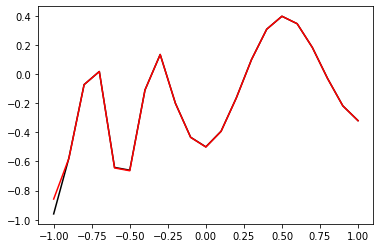

In [57]:
plt.plot(X,D,color='black',label="Train")
plt.plot(X,d,color='red',label="Test")
plt.show()